In [1]:
#!rm -rf global_warming/*

pipeline에서 environment 넣어준거라고 가정

In [8]:
import os

pv 로 들어갈 폴더들 마운트 경로 넣기

# #모든 과정은 dataframe을 가지고 있다는 전제하에 진행함.#

# STAGE 1

### read os env variable

In [4]:
from minio import Minio
import os

In [5]:
minio_url = os.environ["minio_url"]
minio_access_key = os.environ['minio_access_key']
minio_secret_key = os.environ['minio_secret_key']
minio_region = os.environ['minio_region']
minio_bucket_name = os.environ['minio_bucket_name']
competition_name = os.environ['competition_name']

In [37]:
pv_mount_name = os.environ['pv_mount_name']
pv_count = os.environ['pv_count']

### minio_setting... 이 여기 안필요하지 않나?

In [6]:
#아마 minio 글로벌 변수 선언해야 될거 같은데...
#global minio_client
minio_client = Minio(
    minio_url,
    access_key = minio_access_key,
    secret_key = minio_secret_key,
    region = minio_region
)

### kaggle setting

In [7]:
kaggle_access_key = os.environ["kaggle_access_key"]
kaggle_secret_key = os.environ["kaggle_secret_key"]

In [8]:
competition_name = os.environ['competition_name']

In [9]:
#필요한 위치에 정보 입력

kaggle_json =  '{"username":"%s","key":"%s"}'%(kaggle_access_key, kaggle_secret_key)

os.makedirs('~/.kaggle', exist_ok=True)

with open('~/.kaggle/kaggle.json', 'w') as f:
    f.write(kaggle_json)

#root 권한이면 써야됨.
#os.makedirs('/.kaggle')
#with open('~/.kaggle/kaggle.json', 'w') as f:
#    f.write(kaggle_json)
    
#os.makedirs('/home/ubuntu/.kaggle')
#with open('/home/ubuntu/.kaggle/kaggle.json', 'w') as f:
#    f.write(kaggle_json)

#os.makedirs('/home/jovyan/.kaggle')
with open('/home/jovyan/.kaggle/kaggle.json', 'w') as f:
    f.write(kaggle_json)

# Download 받을 폴더 위치

In [10]:
import pandas as pd

In [12]:
from_file_to_file = [['google-research-identify-contrails-reduce-global-warming.zip', 'global_warming/google-research-identify-contrails-reduce-global-warming.zip']]

columns = ['file_in_s3', 'download_to']

download_df = pd.DataFrame(data=from_file_to_file, columns=columns)

In [13]:
download_df

,file_in_s3,download_to
0,google-research-identify-contrails-reduce-glob...,global_warming/google-research-identify-contra...


# download from s3

In [14]:
from data_downloader import Data_downloader

In [15]:
data_downloader = Data_downloader()

data_downloader.set_info_when_download_from_s3(minio_url, minio_access_key, minio_secret_key, minio_region, minio_bucket_name, competition_name)

In [17]:
data_downloader.download_from_s3(file_name_df=download_df)

google-research-identify-contrails-reduce-global-warming.zip download start


### download from kaggle 실전에서는 이걸 써야

In [18]:
#data_downloader = Data_downloader()

#data_downloader.set_info_when_download_from_kaggle(competition_name)

In [19]:
#data_downloader.download_all_from_kaggle(download_folder = "test_test")

# extract data to specific directory

In [1]:
from unzip_to_pv_manager import Unzip_to_pv_manager

In [24]:
unzip = Unzip_to_pv_manager()

In [3]:
zip_file_extracted_file = [['global_warming/google-research-identify-contrails-reduce-global-warming.zip', 'global_warming/[(256,256),npy]/google-research-identify-contrails-reduce-global-warming']]

In [ ]:
for each in zip_file_extracted_file:
    unzip.extract_all(each[0], each[1])

폴더 미리 만들어 두기 (pv 만들어두기)

In [6]:
!mkdir global_warming_0
!mkdir global_warming_1
!mkdir global_warming_2
!mkdir global_warming_3

!mkdir global_warming_4
!mkdir global_warming_5
!mkdir global_warming_6
!mkdir global_warming_7

mkdir: cannot create directory ‘global_warming_1’: File exists
mkdir: cannot create directory ‘global_warming_2’: File exists
mkdir: cannot create directory ‘global_warming_3’: File exists
mkdir: cannot create directory ‘global_warming_4’: File exists
mkdir: cannot create directory ‘global_warming_5’: File exists


## 아... 그러네... pv 마운트 위치 몰록을 적어둬야 겠네 os 환경 변수 통해서 전달해야 될거 아냐...

In [25]:
#실전에는 pv 쪼개기

# 사전에 2GB 데이터를 가지고 extract_all이랑 extract의 시간 차이를 비교해봤는데, 거의 유사했음.

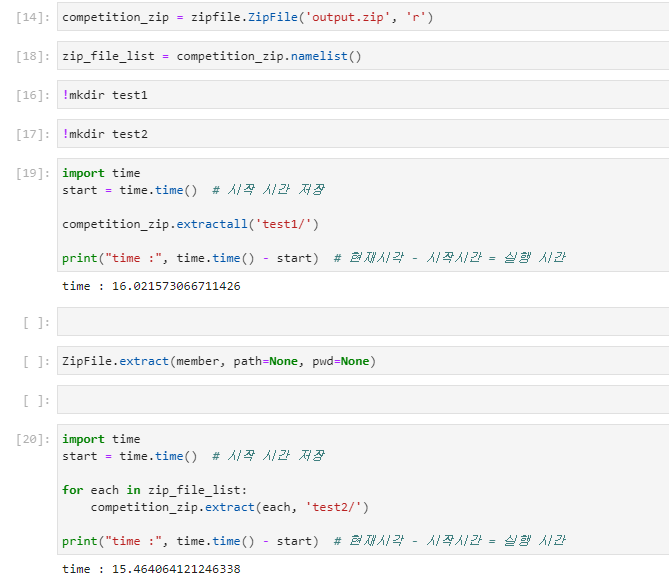

그래서 그냥 extract를 pv로 바로 해버리면?  
디스크에 저장 후 다른 pv로 옮기는 시간 자체가 0이 된다.  
(병렬로 작업하면 오히려 더 빨라질 수 도 있다 이말이다.)

In [38]:
pv_list = []

for i in range(int(pv_count)):
    pv_list.append(pv_mount_name+str(i)+"/global_warming/[(256,256),npy]/")

In [39]:
pv_list

['./global_warming_0/global_warming/[(256,256),npy]/',
 './global_warming_1/global_warming/[(256,256),npy]/',
 './global_warming_2/global_warming/[(256,256),npy]/',
 './global_warming_3/global_warming/[(256,256),npy]/',
 './global_warming_4/global_warming/[(256,256),npy]/',
 './global_warming_5/global_warming/[(256,256),npy]/',
 './global_warming_6/global_warming/[(256,256),npy]/',
 './global_warming_7/global_warming/[(256,256),npy]/']

In [40]:
unzip.extract_to_multiple_path('./global_warming/google-research-identify-contrails-reduce-global-warming.zip', pv_list)

아... 그러네... 이러면 dir 변경해서 저장이 안되잖아. => folder dir에 넣어두자

# STAGE 2

Data preprocessing : not recommended. Ad-hoc pipeline like this don't have any fault tolerance logic (like hadoop map reduce or spark). One fault can hurt all 
data integrit  
But i will run this pipeline for fun!  y

In [28]:
import pandas as pd

In [29]:
train_df = pd.read_csv('train.csv')
valid_df = pd.read_csv('valid.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
from data_preprocessor import Npy_resize_preprocessor as NRP

원본 데이터 (256,256)
npy_size : 450 GB Dataset
img_size : 48.91GB

(128,128)
npy_size :  112.5 GB
img_size :  12.228260869565219 GB

(64,64)
npy_size :  28.125 GB
img_size :  3.0570652173913047 GB

(32,32)
npy_size :  7.03125 GB
img_size :  0.7642663043478262 GB

In [32]:
def change_dir_by_setting(file_path, shape_format, file_format):
    #여기서 파일 이름에 따라서 추가 해서 넣어줘야 되는데? ㅈ 됬다. column에 넣으려니까 안되는데? => 기껏해야 list로 넣어야 됨.
    dirs = file_path.split('/')
    dirs[2] = dirs[2].replace('[(256,256),npy]', shape_format)
    dirs[-1] = dirs[-1].replace('.npy', file_format)
    return '/'.join(dirs)

In [35]:
dir_list = ['[(256,256),jpg]',
            '[(128,128),jpg]',
            '[(64,64),npy]',
            '[(64,64),jpg]',
            '[(32,32),npy]',
            '[(32,32),jpg]'
           ]

format_list = [
    '.jpg',
    '.jpg',
    
    '.npy',
    '.jpg',
    
    '.npy',
    '.jpg',
]

#이거 다하고 나니까 이거 columns에 band 를 쪼갠 이름이 없음... ㅋㅋㅋㅋ 헛짓거리함.
for i in range(len(dir_list)):
    dir_path = dir_list[i]
    file_format = format_list[i]
    
    train_df[dir_path] = train_df['files_path'].map(lambda file_path : change_dir_by_setting(file_path, dir_path, file_format))
    valid_df[dir_path] = valid_df['files_path'].map(lambda file_path : change_dir_by_setting(file_path, dir_path, file_format))
    test_df[dir_path] = test_df['files_path'].map(lambda file_path : change_dir_by_setting(file_path, dir_path, file_format))

In [37]:
#ex

shape_list = [(256,256),(128,128),
              (64,64),(64,64),
              (32,32),(32,32)]

dir_list = ['[(256,256),jpg]',
            '[(128,128),jpg]',
            '[(64,64),npy]',
            '[(64,64),jpg]',
            '[(32,32),npy]',
            '[(32,32),jpg]'
           ]

format_list = [
    '.jpg',
    '.jpg',
    
    '.npy',
    '.jpg',
    
    '.npy',
    '.jpg',
]


#결국 짜긴 짰는데 복잡도가 끔찍하기 그지 없음...

def split_npy(file_name, arr):
    splitted_arr = []
    if file_name == 'human_pixel_masks.npy': #(256, 256, 1)
        splitted_arr = [arr[:,:,0]]
        #print("shape pixel:",splitted_arr[0].shape)
    elif file_name == 'human_individual_masks.npy' : #(256, 256, 1, 4)
        splitted_arr = [arr[:,:,0,i] for i in range(4)]
        #print("shape individual:",splitted_arr[0].shape)
    else: # (256,256,8)
        splitted_arr = [arr[:,:,i] for i in range(8)]
        #print("shape band:",splitted_arr[0].shape)
    return splitted_arr

def add_number_to_name(file_path, number):
    dirs = file_path.split('/')
    tmp = dirs[-1].split('.')
    tmp[0] += '_' + str(number)
    dirs[-1] = '.'.join(tmp)
    return '/'.join(dirs)
    
#file name이랑 
def read_change_save(file_path):
    #file_path = file_path[0]
    #print(file_path)
    arr = NRP.read_npy(file_path)#['files_path'])
    file_name = file_path.split("/")[-1]

    splitted_arr = split_npy(file_name, arr)

    for i in range(len(shape_list)):
        for j in range(len(splitted_arr)):
            reshaped_arr = NRP.resize(splitted_arr[j], shape_list[i])
            path_with_numbered = add_number_to_name(file_path, j)
            name_to_save = change_dir_by_setting(path_with_numbered, dir_list[i], format_list[i])
            NRP.write_with_format(reshaped_arr, name_to_save, format_list[i])

def run(arg_list):
    for arg in arg_list:
        read_change_save(*arg)


In [39]:
train_df['files_path'].map(read_change_save)
valid_df['files_path'].map(read_change_save)
test_df['files_path'].map(read_change_save)

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
Name: files_path, dtype: object

# upload -> Zip 만들어서 올릴 계획이니까.

In [ ]:
!rm -rf global_warming/[(256,256),npy]
!rm google-research-identify-contrails-reduce-global-warming.zip

In [42]:
import os

folder_path = 'global_warming'

file_list = []
 
for path, subdirs, files in os.walk(folder_path):
    for name in files:
        file_list.append(os.path.join(path, name))

In [48]:
tmp_df = pd.DataFrame(data=file_list, columns=['files_path'])

In [49]:
tmp_df.head()

,files_path
0,"global_warming/[(256,256),npy]/google-research..."
1,"global_warming/[(256,256),npy]/google-research..."
2,"global_warming/[(256,256),npy]/google-research..."
3,"global_warming/[(256,256),npy]/google-research..."
4,"global_warming/[(256,256),npy]/google-research..."


In [50]:
def upload_file(file):
    #여기 업로드 하는 작업
    minio_client.fput_object(
        bucket_name = minio_bucket_name,
        object_name = file,
        file_path = file
    )
    return file

In [52]:
tmp_df['files_path'].map(upload_file)

0       global_warming/[(256,256),npy]/google-research...
1       global_warming/[(256,256),npy]/google-research...
2       global_warming/[(256,256),npy]/google-research...
3       global_warming/[(256,256),npy]/google-research...
4       global_warming/[(256,256),npy]/google-research...
                              ...                        
1801    global_warming/[(32,32),jpg]/google-research-i...
1802    global_warming/[(32,32),jpg]/google-research-i...
1803    global_warming/[(32,32),jpg]/google-research-i...
1804    global_warming/[(32,32),jpg]/google-research-i...
1805    global_warming/[(32,32),jpg]/google-research-i...
Name: files_path, Length: 1806, dtype: object

# PV dir에 있는 값들 압축

원한다면 pv를 퍼뜨린 것처럼  
pv를 다시 모아서 압축 할 수 도 있겠지만  
여기서는 4조각으로 나누면 3GB 씩 해서 훨씬 쓰기 좋을테니까 그냥 두겠다.  
=> 반드시 하나의 zip으로 두고 싶다면 파이프 라인을 하나 늘려서 pv를 합치면 된다.

In [41]:
from unzip_to_pv_manager import Unzip_to_pv_manager

In [ ]:
pv_mount_name = os.environ['pv_mount_name']
pv_count = os.environ['pv_count']

In [42]:
unzip = Unzip_to_pv_manager()

In [ ]:
unzip.write_zip(files_base_dir = pv_mount_name+pv_count, name_to_save=pv_count+'.zip')

In [ ]:
def upload_file(file):
    #여기 업로드 하는 작업
    minio_client.fput_object(
        bucket_name = minio_bucket_name,
        object_name = file,
        file_path = file
    )
    return file

In [ ]:
name_to_upload = 'global_warming/'+ pv_count+'.zip'

In [ ]:
upload_file(name_to_upload)